<h1> <center>Twitter - We Rate Dogs - Data Wrangling

<h1> Gather Data</h1>

In [1]:
#import packages
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import requests
import time
import matplotlib.pyplot as plt
%matplotlib inline

<h1> Twitter Archive File

In [2]:
#Read csv file
archive=pd.read_csv('twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


# Image Predictions

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [4]:
#The above output means it succesfully ran without any error, now we are going to open an empty file and write contents into it
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
# Read in tsv file as a Pandas DataFrame    
img = pd.read_csv('image_predictions.tsv', sep='\t')

In [5]:
img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
img.shape

(2075, 12)

<h1> Twitter API

In [7]:
#Create a dictionary  to store twitter credentials
twitter_cred = dict()

#Enter your own consumer_key, consumer_secret, access_key and access_secret_key
consumer_key = 'XXX'
consumer_secret ='XXX'
access_token = 'XXX'
access_secret = 'XXX'

#Saving info to json so that it can be reused in code without exposing to public
with open('twitter_credentials.json', 'w') as secret_info:
 json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)

In [8]:
#Create tweet API to connect to twitter with your credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler = auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
# Create the api to connect to twitter with your credentials
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [9]:
# List for storing result
df_list = []
#List for storing errors
error_list = []

# Calculate the time of excution
start = time.time()

# Get the tweet object for all the teweets in archive dataframe 
for tweet_id in archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        # Print one page to look at the structure of the returned file
        # and the names of attributes
        # print(json.dumps(page, indent = 4))
        #break
        
        favorites = page['favorite_count'] # How many favorites the tweet had
        retweets = page['retweet_count'] # Count of the retweet
        user_followers = page['user']['followers_count'] # How many followers the user had
        user_favourites = page['user']['favourites_count'] # How many favorites the user had
        date_time = page['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Catch the exceptions of the TweepError
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# Calculate the time of execution
end = time.time()
print(end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 221


837366284874571778 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
829374341691346946 _ [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
812747805718642688 _ [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
779123168116150273 _ [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]
770743923962707968 _ [{'code': 144, 'message': 'No status found with that ID.'}]
754011816964026368 _ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 95


680055455951884288 _ [{'code': 144, 'message': 'No status found with that ID.'}]
2930.9525010585785


In [10]:
#Fetch the number results in df_list
len(df_list)

2333

In [11]:
#No. of errors
len(error_list)

23

It took us about 57 minutes approximately to fetch results

In [12]:
#Reiterating the process to fetch from error list
errors=[]
for e in error_list:
    try:
        favorites = page['favorite_count']
        retweets = page['retweet_count']
        user_followers = page['user']['followers_count']
        user_favourites = page['user']['favourites_count']
        date_time = page['created_at']
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception:
        #In case of erros, add the tweet id to errors 
        print(str(tweet_id)+ " _ " + str(e))
        errors.append(e)

In [13]:
#Confirming the no. of errors
len(errors)

0

In [14]:
#Create a dataframe
tweets_json=pd.DataFrame(df_list,columns=['tweet_id','favorites','retweets','user_followers','user_favourites','date_time'])

In [15]:
# Save the dataframe to json.txt 
tweets_json.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [16]:
#Read json.txt into dataframe
tweet=pd.read_csv('tweet_json.txt',encoding='utf-8')
tweet.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,37151,7946,8343816,143219,2017-08-01 16:23:56+00:00
1,892177421306343426,31948,5901,8343816,143219,2017-08-01 00:17:27+00:00
2,891815181378084864,24066,3902,8343816,143219,2017-07-31 00:18:03+00:00
3,891689557279858688,40464,8092,8343816,143219,2017-07-30 15:58:51+00:00
4,891327558926688256,38701,8783,8343816,143219,2017-07-29 16:00:24+00:00


In [17]:
tweet.shape

(2356, 6)

In [18]:
tweet['tweet_id'].duplicated().value_counts()

False    2333
True       23
Name: tweet_id, dtype: int64

In [19]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id           2356 non-null int64
favorites          2356 non-null int64
retweets           2356 non-null int64
user_followers     2356 non-null int64
user_favourites    2356 non-null int64
date_time          2356 non-null object
dtypes: int64(5), object(1)
memory usage: 110.5+ KB


In [20]:
tweet.to_csv("outputfile.csv", sep=",", decimal=",")

<h4>Gathering Conclusions:</h4>
    1. Gathered data from various sources and saved them into a dataframe for next steps <br>
    2. 'twitter_archive_enhanced.csv' has been given to us. It has been read into <b> df</b> dataframe and consists of 2356 rows.<br>
    3. The tweet image prediction file (.tsv) has been downloaded programatically using requests library from the url below:
     https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv <br>
    4. Using tweet_id, scraping Twitter APi using tweepy and storing each tweet's entire set of json data into <b>tweet_json.txt</b>.This dataframe consists of around 2356 records with 24 duplicate tweet ids.
    
    

# Assess Twitter_archive File

In [21]:
#Assessing Twitter_archive data
archive=pd.read_csv('twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [22]:
#Assessing Programmatically
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [23]:
#Checking the min value of rating_numerator
archive['rating_numerator'].min()

0

In [24]:
#Checking the max value of rating_denominator
archive['rating_numerator'].max()

1776

In [25]:
#Checking the min value of rating_denomiator
archive['rating_denominator'].min()

0

In [26]:
#Checking the max value of rating_denomiator
archive['rating_denominator'].max()

170

In [27]:
archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [28]:
archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [29]:
#Checking type of timestamp
type(archive['timestamp'][0])

str

In [30]:
#Checking for duplicates
archive.duplicated().sum()

0

In [31]:
#checking for duplicates in column tweetid
archive['tweet_id'].nunique()

2356

In [32]:
#Checking names of dogs
archive['name'].value_counts()

None            745
a                55
Charlie          12
Lucy             11
Cooper           11
Oliver           11
Penny            10
Lola             10
Tucker           10
Bo                9
Winston           9
the               8
Sadie             8
Toby              7
Daisy             7
Bailey            7
an                7
Buddy             7
Stanley           6
Koda              6
Leo               6
Milo              6
Jack              6
Rusty             6
Scout             6
Dave              6
Oscar             6
Jax               6
Bella             6
Bentley           5
               ... 
Kingsley          1
Staniel           1
Pepper            1
Glacier           1
Rumble            1
Kathmandu         1
Charl             1
Jimbo             1
Berb              1
Benny             1
Burt              1
Rufio             1
Kuyu              1
Alexanderson      1
Strudel           1
Glenn             1
Biden             1
Fwed              1
Pippin            1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9D86B1E48>,
      dtype=object)

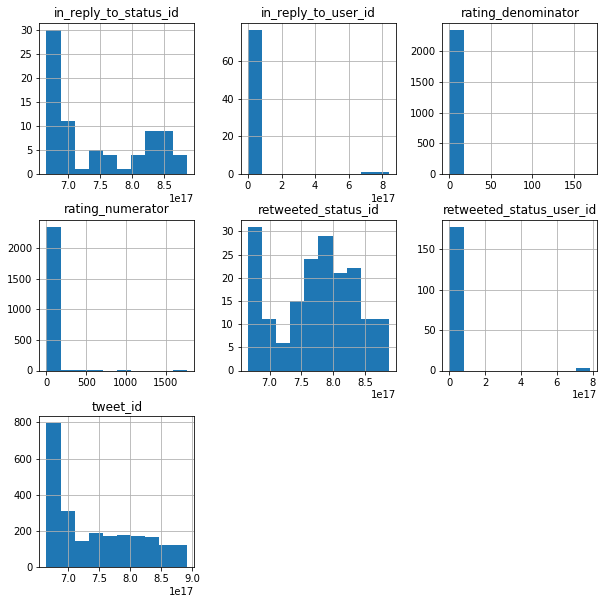

In [33]:
#Plotting a histogram
archive.hist(figsize=(10,10))

<h3>Quality Issues in Twitter-archive files</h3>
1. Some columns like in_reply_to_status_id,in_reply_to_user_id,tweet_id have a datatype of float instead of int if required. Also, duplicate tweets should be dropped.
<br>2. Timestamp should be converted into datetime format.It is of str format presently.
<br>3. Around 745 records found in name category which are None.They seem to be missing values typed as None. They must be cleaned.
<br> 4. Some ratings do not make sense. They must be explored and cleaned.


# Assess Images file      

In [34]:
img=pd.read_csv('image_predictions.tsv',sep='\t')
img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [35]:
img.shape

(2075, 12)

In [36]:
img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [37]:
img.duplicated().sum()

0

In [38]:
#checking for duplicates in jpg_url column
img['jpg_url'].duplicated().sum()

66

In [39]:
img['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
Cardigan                      19
web_site                      19
Eskimo_dog                    18
Maltese_dog                   18
teddy                         18
beagle                        18
Shetland_sheepdog             18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
kuvasz                        16
Italian_greyhound             16
          

<h3>Quality Issues in Images File:</h3>
    1. 2075 rows as opposed to Twitter Archive file
<h3> Tidiness issues in Images file</h3>
  1. Unnecessary extra columns for P1_dog, P2_dog and P3_dog. They can be combined into one column.

# Assess Twitter API files

In [40]:
tweet=pd.read_csv('outputfile.csv')
tweet.head()

,Unnamed: 0,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,0,892420643555336193,37151,7946,8343816,143219,2017-08-01 16:23:56+00:00
1,1,892177421306343426,31948,5901,8343816,143219,2017-08-01 00:17:27+00:00
2,2,891815181378084864,24066,3902,8343816,143219,2017-07-31 00:18:03+00:00
3,3,891689557279858688,40464,8092,8343816,143219,2017-07-30 15:58:51+00:00
4,4,891327558926688256,38701,8783,8343816,143219,2017-07-29 16:00:24+00:00


In [41]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 7 columns):
Unnamed: 0         2356 non-null int64
tweet_id           2356 non-null int64
favorites          2356 non-null int64
retweets           2356 non-null int64
user_followers     2356 non-null int64
user_favourites    2356 non-null int64
date_time          2356 non-null object
dtypes: int64(6), object(1)
memory usage: 128.9+ KB


In [42]:
tweet.columns

Index(['Unnamed: 0', 'tweet_id', 'favorites', 'retweets', 'user_followers',
       'user_favourites', 'date_time'],
      dtype='object')

In [43]:
tweet['tweet_id'].nunique()

2333

In [44]:
tweet['user_followers'].nunique()

117

In [45]:
type(tweet['date_time'][0])

str

<h3> Quality issues in Twitter API data </h3>
1. Tweet id has duplicate values
<br> 2. Date_time column should be changed to datetime datatype
<br>3. Drop unnecessary columns not useful for analysis
<br>4. Check for duplicates and clean them.



<h3>Overall Tidiness issues</h3>
1. All the three files have a common column name 'tweet_id'. We can merge the three files together using this common column.
<br>2. Some columns can be merged and made into one column eg p1_conf,p2_conf,p3_conf can be merged into one column.<br>
3. Similarly doggo, floofers,puppers and puppo can be merged into one column.


# Data Cleaning

In [46]:
#Merge three files into one dataframe called merge
merge=pd.merge(archive, img, how='inner',on= ['tweet_id'])
merge=pd.merge(merge,tweet,how='inner',on=['tweet_id'])
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084 entries, 0 to 2083
Data columns (total 34 columns):
tweet_id                      2084 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2084 non-null object
source                        2084 non-null object
text                          2084 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2084 non-null object
rating_numerator              2084 non-null int64
rating_denominator            2084 non-null int64
name                          2084 non-null object
doggo                         2084 non-null object
floofer                       2084 non-null object
pupper                        2084 non-null object
puppo                         2084 non-null object
jpg_url                       2084 

In [47]:
#Drop unnamed column
merge.drop('Unnamed: 0',axis=1,inplace=True)

In [48]:
merge.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorites', 'retweets',
       'user_followers', 'user_favourites', 'date_time'],
      dtype='object')

<h4>Quality Issue 1 

<h4>Define:Check for duplicates

In [49]:
#Check for duplicate rows
merge.duplicated().sum()

23

<h4>Code

In [50]:
#Drop duplicates
merge.drop_duplicates(inplace=True)

<h4> Test

In [51]:
merge.shape

(2061, 33)

In [52]:
merge.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorites', 'retweets',
       'user_followers', 'user_favourites', 'date_time'],
      dtype='object')

<h4> Quality Issue 2

<h4>Define :Interested in Original tweets under Retweeted Status ID

Drop all rows containing retweets, where these columns will be non-null: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp

<h4> Code

In [53]:
sum(merge.retweeted_status_id.notnull())

74

In [54]:
merge = merge[merge.retweeted_status_id.isna()]

<h4> Test

In [55]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 33 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null object
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
jpg_url                       1987 non

<h4>Quality Issue 3:

<h4>Define:Drop all rows that are replies, those that have non-null values in these columns: in_reply_to_status_id and in_reply_to_user_id.

<h4>Code

In [56]:
sum(merge.in_reply_to_status_id.notnull())

23

In [57]:
merge = merge[merge.in_reply_to_status_id.isna()]

<h4>Test

In [58]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2060
Data columns (total 33 columns):
tweet_id                      1964 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1964 non-null object
source                        1964 non-null object
text                          1964 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1964 non-null object
rating_numerator              1964 non-null int64
rating_denominator            1964 non-null int64
name                          1964 non-null object
doggo                         1964 non-null object
floofer                       1964 non-null object
pupper                        1964 non-null object
puppo                         1964 non-null object
jpg_url                       1964 non-n

<h4>Quality Issue 4

<h4> Define: :  Dropping unnecessary columns not useful for analysis

<h4>Code:

In [59]:
#dropping these two columns as they will not be useful for analysis
merge.drop(['in_reply_to_status_id','in_reply_to_user_id'],inplace=True,axis=1)

In [60]:
#Dropping the columns where there are many missing values
merge.drop(['retweeted_status_timestamp','retweeted_status_user_id'],axis=1,inplace=True)

In [61]:
merge.drop(['retweeted_status_id'],axis=1,inplace=True)

<h4> Test

In [62]:
#Confirming changes
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2060
Data columns (total 28 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
doggo                 1964 non-null object
floofer               1964 non-null object
pupper                1964 non-null object
puppo                 1964 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null int64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null bool
p2                    1964 non-null object
p2_conf               1964 non-null float64
p2_dog                1964 non-null bool
p3                    1964 non-null obj

<h4>Quality Issue 5:

<h4>Define: Convert datatype of timestamp

<h4>Code

In [63]:
#Convert timestamp into datetime format
merge['timestamp'] = pd.to_datetime(merge['timestamp'], format = "%Y-%m-%d %H:%M:%S")

<h4> Test

In [64]:
type(merge['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

<h4>Quality Issue 6:

<h4>Define :Check if there is a floating rating from text column

<h4> Code

In [65]:
merge[merge.text.str.contains(r'(\d+(\.\d+))\/(\d+)')]['text'].values

C:\Users\arryg\Anaconda3\envs\shweta\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


array(['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
       "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
       "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
       'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD'],
      dtype=object)

In [66]:
A=merge['text'].str.extract(('(\d+(\.\d+)|(\d+))\/(\d+)'), expand=False)
A.columns=['col1','col2','col3','col4']
A.head()

,col1,col2,col3,col4
0,13,NaN,13,10
1,13,NaN,13,10
2,12,NaN,12,10
3,13,NaN,13,10
4,12,NaN,12,10


In [67]:
A[A.col1!=A.col3]

,col1,col2,col3,col4
40,13.5,.5,NaN,10
548,9.75,.75,NaN,10
603,11.27,.27,NaN,10
1440,11.26,.26,NaN,10


In [68]:
merge['rating_numerator']=A.col1.astype(float)

In [69]:
merge['rating_denominator']=A.col4.astype(float)

<h4> Test

In [70]:
merge['rating_numerator'].value_counts()

12.00      444
10.00      416
11.00      392
13.00      249
9.00       150
8.00        95
7.00        52
14.00       33
6.00        32
5.00        32
3.00        19
4.00        16
2.00         9
1.00         5
60.00        1
24.00        1
99.00        1
1776.00      1
13.50        1
11.27        1
165.00       1
11.26        1
0.00         1
84.00        1
9.75         1
45.00        1
88.00        1
144.00       1
44.00        1
121.00       1
204.00       1
50.00        1
80.00        1
420.00       1
Name: rating_numerator, dtype: int64

In [71]:
merge['rating_denominator'].value_counts()

10.0     1947
50.0        3
80.0        2
11.0        2
170.0       1
150.0       1
2.0         1
120.0       1
110.0       1
40.0        1
90.0        1
20.0        1
7.0         1
70.0        1
Name: rating_denominator, dtype: int64

<h4>Quality issue 7 :

<h4>Define : Numerator values are too high

<h4>Code

In [72]:
#fetch rows where numerator values > 50
index_num=merge.loc[merge['rating_numerator']>50].index
index_num

Int64Index([336, 724, 791, 913, 1011, 1036, 1120, 1369, 1500, 1559, 1783], dtype='int64')

In [73]:
#drop those rows
merge.drop(index_num,inplace=True)

<h4> Test

In [74]:
merge['rating_numerator'].value_counts()

12.00    444
10.00    416
11.00    392
13.00    249
9.00     150
8.00      95
7.00      52
14.00     33
6.00      32
5.00      32
3.00      19
4.00      16
2.00       9
1.00       5
11.26      1
9.75       1
24.00      1
0.00       1
50.00      1
45.00      1
44.00      1
13.50      1
11.27      1
Name: rating_numerator, dtype: int64

<h4>Quality Issue 8:

<h4>Define: Denominator Values don't make sense

<h4>Code

In [75]:
#fetch rows where denominator values are not equalling 10
index_denom=merge.loc[merge['rating_denominator']!=10].index
index_denom

Int64Index([406, 865, 956, 990, 1054, 1196, 1394, 2040], dtype='int64')

In [76]:
#drop those rows
merge.drop(index_denom,inplace=True)

<h4> Test

In [77]:
#confirming changes
merge.shape

(1945, 28)

<h4>Quality  Issue 9

<h4>Define  : Some Names have not been input properly

<h4> Code

In [78]:
#Check name column
merge['name'].value_counts()

None            512
a                54
Cooper           10
Oliver           10
Charlie          10
Penny             9
Tucker            9
Lucy              9
Winston           8
Sadie             8
Daisy             7
Toby              7
the               7
Lola              7
Koda              6
Bo                6
Bella             6
Jax               6
Stanley           6
Bailey            5
Dave              5
Oscar             5
Milo              5
Buddy             5
an                5
Scout             5
Louis             5
Rusty             5
Leo               5
Chester           5
               ... 
Layla             1
Dotsy             1
Coopson           1
Lenox             1
Logan             1
Fwed              1
Jameson           1
Biden             1
Eevee             1
Chuq              1
Cedrick           1
Tanner            1
Chloe             1
Jim               1
Shakespeare       1
Godzilla          1
Darby             1
Tuco              1
Venti             1


In [79]:
#We see that there are few invalud names like a, an, the. Replace them with none
list_invalid=['a','an','my','the']
for i in list_invalid:
    merge['name'].replace(i,'None',inplace=True)

<h4> Test

In [80]:
#Confirm changes
merge['name'].value_counts()

None           579
Charlie         10
Oliver          10
Cooper          10
Lucy             9
Tucker           9
Penny            9
Sadie            8
Winston          8
Lola             7
Toby             7
Daisy            7
Stanley          6
Jax              6
Bella            6
Koda             6
Bo               6
Oscar            5
Buddy            5
Chester          5
Louis            5
Rusty            5
Bailey           5
Dave             5
Leo              5
Scout            5
Milo             5
Bentley          4
Jerry            4
Bear             4
              ... 
Boots            1
Tom              1
Hector           1
Tater            1
Danny            1
infuriating      1
Rover            1
Jockson          1
Bookstore        1
Grady            1
Anna             1
Durg             1
Dunkin           1
Koko             1
Bobble           1
Brockly          1
Paull            1
Kawhi            1
not              1
Longfellow       1
Cecil            1
Kenny       

<h4>Quality Issue 10

<h4>Define : Sources are links instead of texts

<h4> Code

In [81]:
#Check sources column
merge['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1908
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       9
Name: source, dtype: int64

In [82]:
# Simplify the source
merge['source']=merge['source'].replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
                                                                          'Twitter for iphone')
merge['source'] =  merge['source'].replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
                                                                           'Twitter Web Client')
merge['source'] =  merge['source'].replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
                                                                           'TweetDeck')

<h4>Test

In [83]:
#confirming changes
merge['source'].value_counts()

Twitter for iphone    1908
Twitter Web Client      28
TweetDeck                9
Name: source, dtype: int64

In [84]:
# Change datatype to category for visualization purposes
merge['source'] = merge['source'].astype('category')

<h4>Add a column to fetch Gender

In [85]:
#Retrieve the gender of dogs
male=['He','he','him','his',"he's",'himself']
female=['She','her','she','hers','herself',"she's"]
gender=[]
for text in merge['text']:
     if any(map(lambda v:v in male, text.split())):
        gender.append('male')
    # Female
     elif any(map(lambda v:v in female, text.split())):
        gender.append('female')
    # If group or not specified
     else:
        gender.append('NaN')

In [86]:
#Check if they have been appended
len(gender)

1945

In [87]:
#add a new column to the dataframe merge and the gender
merge['gender']=gender

In [88]:
merge.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time,gender
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,...,False,banana,0.076110,False,37151,7946,8343816,143219,2017-08-01 16:23:56+00:00,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,...,True,papillon,0.068957,True,31948,5901,8343816,143219,2017-08-01 00:17:27+00:00,female
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,...,True,kelpie,0.031379,True,24066,3902,8343816,143219,2017-07-31 00:18:03+00:00,male
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,...,True,spatula,0.040836,False,40464,8092,8343816,143219,2017-07-30 15:58:51+00:00,female
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,...,True,German_short-haired_pointer,0.175219,True,38701,8783,8343816,143219,2017-07-29 16:00:24+00:00,male


In [89]:
merge['gender'].value_counts()


NaN       1096
male       629
female     220
Name: gender, dtype: int64

<h4>Tidiness Issue 1:

<h4>Define : Merging doggo,floofer,pupper,puppo into one column

<h4>Code

In [90]:
merge.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1643
1,None,None,None,puppo,22
2,None,None,pupper,None,201
3,None,floofer,None,None,7
4,doggo,None,None,None,62
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,8
7,doggo,floofer,None,None,1


In [91]:
#convert 'None' or np.NaN to empty string "
merge.doggo.replace('None', '', inplace=True)
merge.doggo.replace(np.NaN, '', inplace=True)
merge.floofer.replace('None', '', inplace=True)
merge.floofer.replace(np.NaN, '', inplace=True)
merge.pupper.replace('None', '', inplace=True)
merge.pupper.replace(np.NaN, '', inplace=True)
merge.puppo.replace('None', '', inplace=True)
merge.puppo.replace(np.NaN, '', inplace=True)

In [92]:
merge['dog_stages'] = merge.doggo + merge.floofer + merge.pupper + merge.puppo
merge.loc[merge.dog_stages == 'doggopupper', 'stage'] = 'doggo, pupper'
merge.loc[merge.dog_stages == 'doggopuppo', 'stage'] = 'doggo, puppo'
merge.loc[merge.dog_stages == 'doggofloofer', 'stage'] = 'doggo, floofer'

<h4> Test

In [93]:
merge.dog_stages.value_counts()

                1643
pupper           201
doggo             62
puppo             22
doggopupper        8
floofer            7
doggopuppo         1
doggofloofer       1
Name: dog_stages, dtype: int64

In [94]:
merge['dog_stages'].replace('','NA',inplace=True)

In [95]:
merge.dog_stages.value_counts()

NA              1643
pupper           201
doggo             62
puppo             22
doggopupper        8
floofer            7
doggopuppo         1
doggofloofer       1
Name: dog_stages, dtype: int64

<h4>Tidiness Issue 2

<h4>Define : Consolidating Image prediction into one column

<h4>Code

In [97]:
# Code Tidy: Consolidating image prediction into one column
merge['breed1'] = merge[merge['p1_dog'] == True].p1
merge['breed2'] = merge[((merge['p1_dog'] == False) &(merge['p2_dog'] == True))].p2
merge['breed3'] = merge[((merge['p1_dog'] == False) &(merge['p2_dog'] == False) &(merge['p3_dog'] == True))].p3
merge['dog_breeds'] = merge[['breed1','breed2','breed3']].fillna('').sum(axis=1)


<h4>Test

In [98]:
merge.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,user_followers,user_favourites,date_time,gender,dog_stages,stage,breed1,breed2,breed3,dog_breeds
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,,,...,8343816,143219,2017-08-01 16:23:56+00:00,NaN,NA,NaN,NaN,NaN,NaN,
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,,,...,8343816,143219,2017-08-01 00:17:27+00:00,female,NA,NaN,Chihuahua,NaN,NaN,Chihuahua
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,,,...,8343816,143219,2017-07-31 00:18:03+00:00,male,NA,NaN,Chihuahua,NaN,NaN,Chihuahua
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,,,...,8343816,143219,2017-07-30 15:58:51+00:00,female,NA,NaN,NaN,Labrador_retriever,NaN,Labrador_retriever
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,,,...,8343816,143219,2017-07-29 16:00:24+00:00,male,NA,NaN,basset,NaN,NaN,basset


In [99]:
merge['dog_breeds'].replace('','Not available',inplace=True)

In [100]:
merge.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,user_followers,user_favourites,date_time,gender,dog_stages,stage,breed1,breed2,breed3,dog_breeds
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,,,...,8343816,143219,2017-08-01 16:23:56+00:00,NaN,NA,NaN,NaN,NaN,NaN,Not available
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,,,...,8343816,143219,2017-08-01 00:17:27+00:00,female,NA,NaN,Chihuahua,NaN,NaN,Chihuahua
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,,,...,8343816,143219,2017-07-31 00:18:03+00:00,male,NA,NaN,Chihuahua,NaN,NaN,Chihuahua
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,,,...,8343816,143219,2017-07-30 15:58:51+00:00,female,NA,NaN,NaN,Labrador_retriever,NaN,Labrador_retriever
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,,,...,8343816,143219,2017-07-29 16:00:24+00:00,male,NA,NaN,basset,NaN,NaN,basset


In [133]:
#Write to output file and name is twitter_master_data
merge.to_csv("twitter_archive_master.csv", sep=",", decimal=".",index=False)

# Analyze and Visualize Data

# Exploring and Analyzing Ratings,Favorites and Retweets over time

In [103]:
#Creating a ratio variable and create divide rating_numerator by rating_denominator
merge['ratio']= merge['rating_numerator']/merge['rating_denominator']
merge.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,user_favourites,date_time,gender,dog_stages,stage,breed1,breed2,breed3,dog_breeds,ratio
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,,,...,143219,2017-08-01 16:23:56+00:00,NaN,NA,NaN,NaN,NaN,NaN,Not available,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,,,...,143219,2017-08-01 00:17:27+00:00,female,NA,NaN,Chihuahua,NaN,NaN,Chihuahua,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,,,...,143219,2017-07-31 00:18:03+00:00,male,NA,NaN,Chihuahua,NaN,NaN,Chihuahua,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,,,...,143219,2017-07-30 15:58:51+00:00,female,NA,NaN,NaN,Labrador_retriever,NaN,Labrador_retriever,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,,,...,143219,2017-07-29 16:00:24+00:00,male,NA,NaN,basset,NaN,NaN,basset,1.2


In [104]:
#Storing copy of merge dataframe with certain columns required for analysis
time=merge[['timestamp', 'retweets', 'favorites', 'ratio']].copy()

In [105]:
#Visualizing wrt timestamp
time.set_index('timestamp', inplace=True)

Text(0, 0.5, 'Rating')

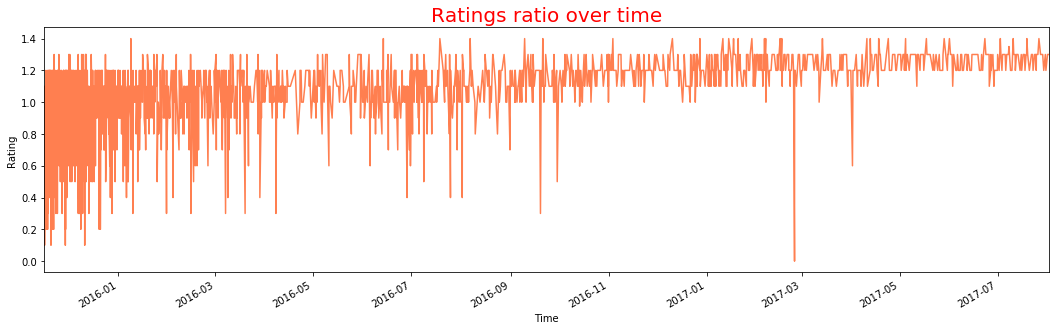

In [129]:
f, ax = plt.subplots(figsize=(18,5))
time['ratio'].plot(kind='line',color='coral')
plt.xlabel('Time')
plt.title('Ratings ratio over time',fontsize=20,color='red')
plt.ylabel('Rating')

In [130]:
time['ratio'].mean()

1.0536647814910025

On an average, the ratings over time is observed to be around 1.05 with dips observed in few months. Maximum drop in rating was observed in March, 2017.

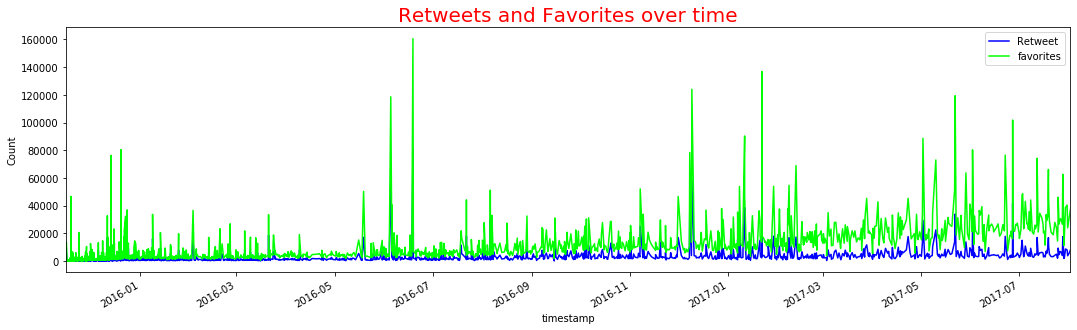

In [107]:
f, ax = plt.subplots(figsize=(18,5))
time['retweets'].plot(kind='line', color='blue',label='Retweet')
time['favorites'].plot(kind='line',color='lime',label='favorites')
plt.title('Retweets and Favorites over time',fontsize=20,color='red')
plt.ylabel('Count')
plt.legend()

In [108]:
time['favorites'].mean()

8535.06323907455

In [109]:
time['retweets'].mean()

2542.099742930591

<b>From the above graphs we see that in July,2016, the number of favorites were at the peak with a whopping count of 160000. The number of retweets have always been less compared to that favorites with the highest count in retweets recorded in the month of June 2017.It is safe to say that for every 3 favorites on a tweet, one retweet is possible.

# Exploring and Visualizing Dog Ratings

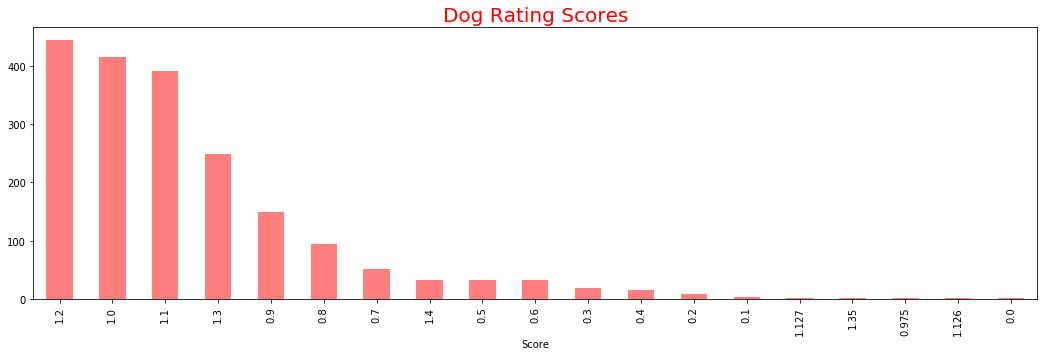

In [110]:
f, ax = plt.subplots(figsize=(18,5))
merge['ratio'].value_counts().plot(kind='bar',color='red',alpha=0.50)
plt.title('Dog Rating Scores',fontsize=20,color='red')
plt.xlabel('Score');

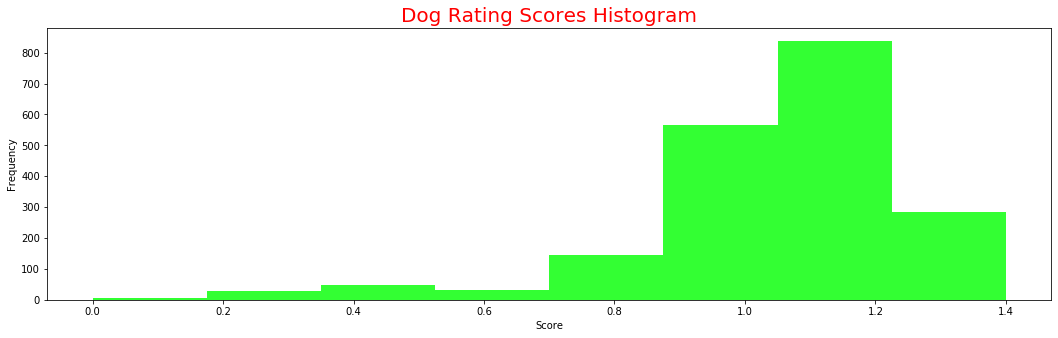

In [111]:
f, ax = plt.subplots(figsize=(18,5))
merge['ratio'].plot(kind='hist',bins=8,color='lime',alpha=0.80)
plt.title('Dog Rating Scores Histogram',fontsize=20,color='red')
plt.xlabel('Score');

In [131]:
#Mean of ratio
merge.ratio.mean()

1.0536647814910025

In [132]:
#median of Ratio
merge.ratio.median()

1.1

In [114]:
#Standard deviation of Ratio
merge.ratio.std()

0.2171098357528362

<b>We see that majority of the scores lie between the ratio 1.1 and 1.2 with the mean being 1.05 and median being 1.1 meaning it is left skewed.Also, we observe that the kurtosis is high with most of the datapoints lying between 1.1 and 1.2. Majority of the dogs have been rated good with few exceptions where the dogs have been rated 0.

# Exploring and Visualizing Breed

In [115]:
# What species of dogs most frequently appear on WeRateDogs Twitter 
breed_df = merge.groupby(['dog_breeds']).count();
breed_fav_df = merge.groupby(['dog_breeds']).sum();

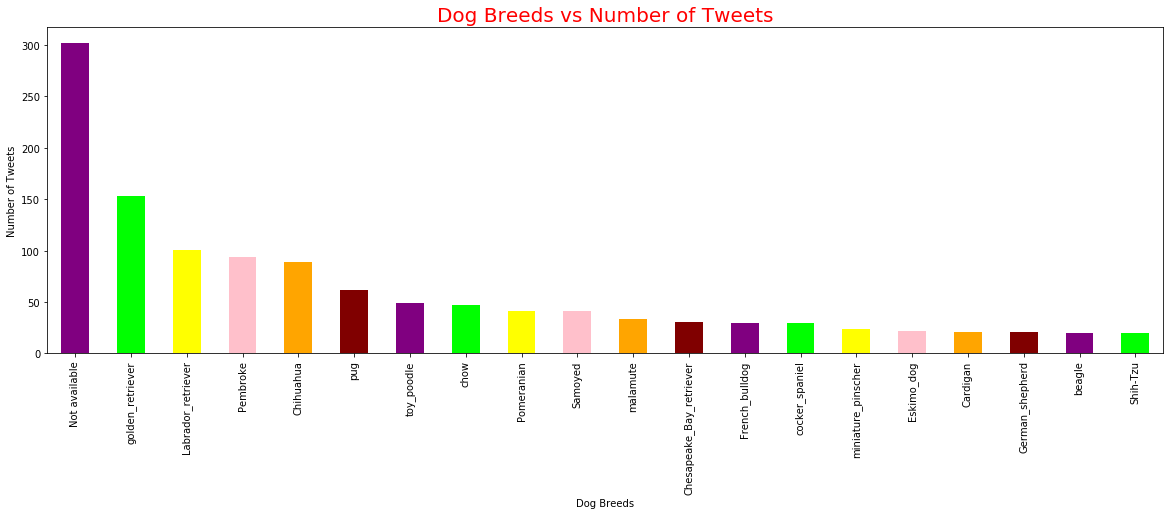

In [116]:
#Visualizing Dog breeds and Number of tweets
popular_dogs = breed_df.sort_values(['tweet_id'], ascending = False).head(20)
popular_dogs = popular_dogs.reset_index()
popular_dogs.plot(x='dog_breeds', y='tweet_id', kind='bar', figsize=(20,6),color=['purple','lime','yellow','pink','orange','maroon'] ,legend=None);
plt.ylabel('Number of Tweets')
plt.xlabel('Dog Breeds')
plt.title('Dog Breeds vs Number of Tweets',fontsize=20,color='Red');

Text(0.5, 1.0, 'Top Rated Dog breeds')

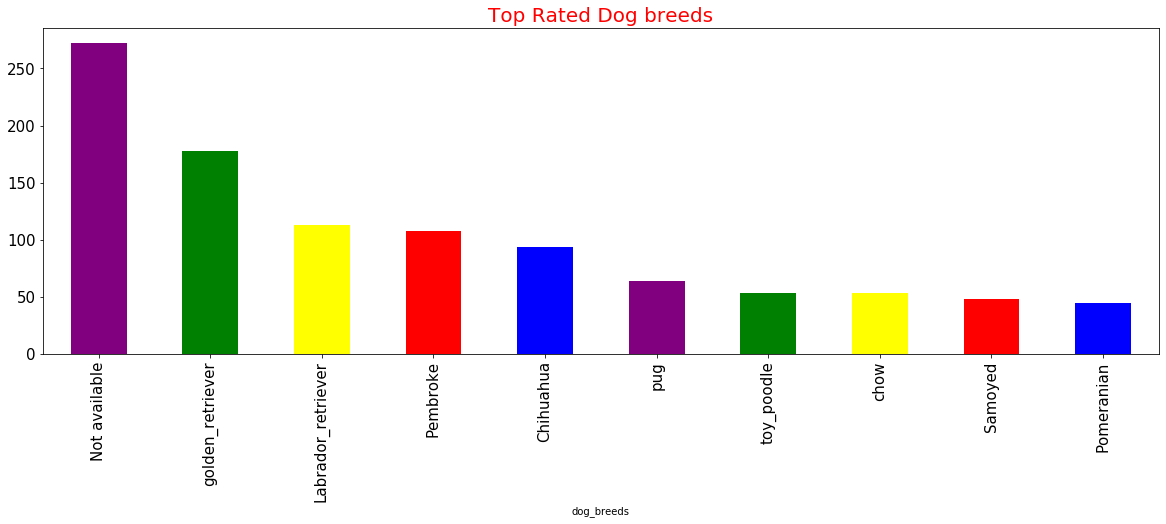

In [117]:
#Top rated breeds
breed_fav_df['ratio'].nlargest(10).plot(kind='bar',figsize=(20,6),color=['purple','green','yellow','red','blue'], fontsize=15)
plt.title('Top Rated Dog breeds', fontsize=20,color='red')

Text(0.5, 0, 'Favorites ')

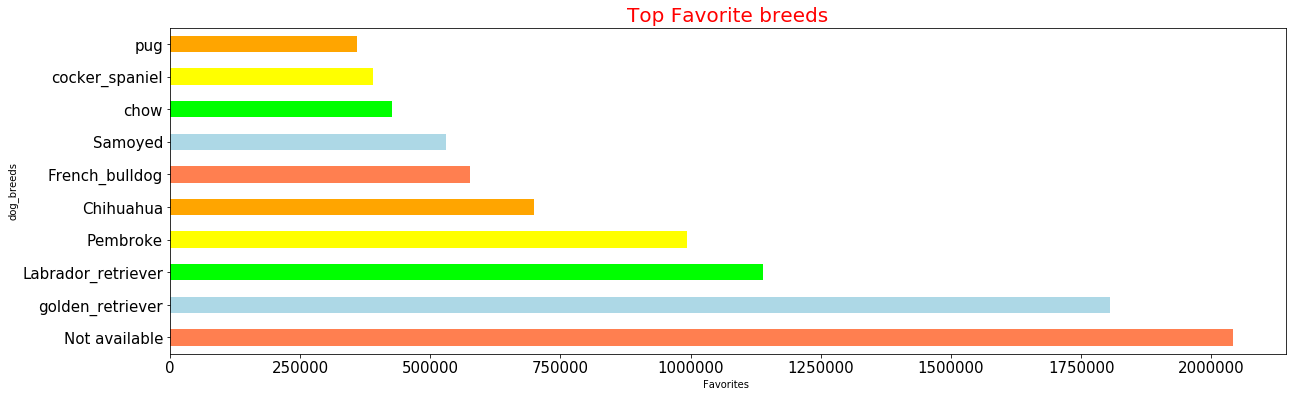

In [118]:
#Top liked breeds
breed_fav_df['favorites'].nlargest(10).plot(kind='barh',figsize=(20,6),color=['coral','lightblue','lime','yellow','orange'], fontsize=15)
plt.title('Top Favorite breeds', fontsize=20,color='red')
plt.xlabel('Favorites ')

<b>From the graphs above, it is clear that Golden Retriever is the top most popular breed of dog with maximum likes, retweets and ratings followed by Labrador_retriever, Pembroke and Chihuahua.

# Visualizing Stages

Text(0.5, 1.0, 'Ratings by Stages of Dogs')

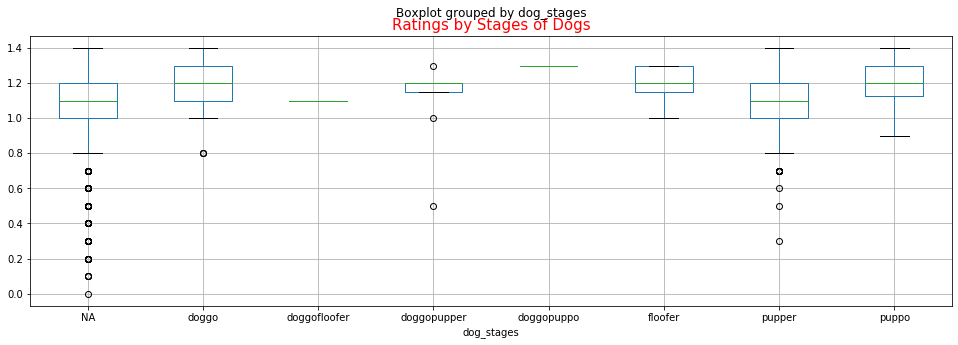

In [119]:
#Plotting boxplot for all stages by rating(ratio)
merge.boxplot(column='ratio', by='dog_stages',figsize=(16,5));
plt.title('Ratings by Stages of Dogs',fontsize=15,color='red')

In [120]:
merge.groupby('dog_stages')['ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stages,,,,,,,,
NA,1643.0,1.044401,0.222665,0.0,1.000,1.1,1.2,1.4
doggo,62.0,1.187097,0.147641,0.8,1.100,1.2,1.3,1.4
doggofloofer,1.0,1.100000,NaN,1.1,1.100,1.1,1.1,1.1
doggopupper,8.0,1.100000,0.256348,0.5,1.150,1.2,1.2,1.3
doggopuppo,1.0,1.300000,NaN,1.3,1.300,1.3,1.3,1.3
floofer,7.0,1.200000,0.115470,1.0,1.150,1.2,1.3,1.3
pupper,201.0,1.063816,0.173602,0.3,1.000,1.1,1.2,1.4
puppo,22.0,1.200000,0.130931,0.9,1.125,1.2,1.3,1.4


<b>Looks like dogger,pupper and puppo get the maximum ratings. On an average doggo  gets rated better than the rest of the stages. 

<h3>Exploring Dog Gender

Text(0.5, 1.0, 'Gender Distribution')

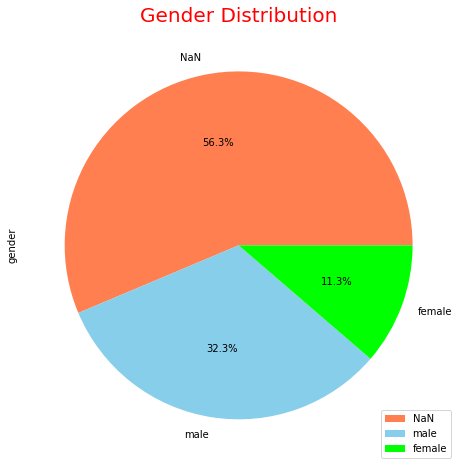

In [121]:
merge['gender'].value_counts().plot(kind='pie', figsize=(8,8),colors=['coral','skyblue','lime'],autopct='%1.1f%%',legend=True)
plt.title("Gender Distribution", fontsize=20,color='red')

In [122]:
#Evaluate the mean rating for male dogs
merge[merge['gender'] == "male"]['rating_numerator'].mean()

10.654610492845787

In [123]:
#Evaluate the mean rating for female dogs
merge[merge['gender'] == "female"]['rating_numerator'].mean()

11.334090909090909

In [124]:
np.std(merge[merge['gender'] == "male"]['rating_numerator'])

1.9182524794286742

In [125]:
np.std(merge[merge['gender'] == "female"]['rating_numerator'])

1.493461991149512

<b> We see that Female dogs rate a little higher than the male dogs.Also, we note that there is not much difference observed in the standard deviations between the two  genders.